# Important note

1. This notebook is built upon this quickstarter by https://www.kaggle.com/code/ambrosm/msci-multiome-quickstart

2. It reads the Multime traning data in sparse mode,from this dataset: https://www.kaggle.com/datasets/sbunzini/open-problems-msci-multiome-sparse-matrices

3. During CV this NB reads the whole training dataset,in four chunks. It takes 33 minutes to complete.

4. It uses truncatedSVD for reducing the number of features, to 512.

5. The model is Ridge. I tried LinearRegression and KNN  (very fast) and DecisionTrees, LinearSVD (dual=False),LGBM and CatBoost (excruciatingly slow).

6. The CV is about 0.658, which is not an improvement. 

I hope this helps.

# Multiome Quickstart

This notebook shows how to cross-validate a baseline model and create a submission for the Multiome part of the *Multimodal Single-Cell Integration* competition without running out of memory.

It does not show the EDA - see the separate notebook [MSCI EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/ambrosm/msci-eda-which-makes-sense).

The baseline model for the other part of the competition (CITEseq) is [here](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart).

In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
import scipy.sparse as sps
from scipy.sparse.linalg import lsqr
import math

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Dropout,Dense, Input, Concatenate, Conv1D, Flatten, MaxPool1D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
#from sklearn.preprocessing import StandardScaler, scale
#from sklearn.decomposition import PCA
#from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error

#import lightgbm as lgb
#import catboost as cb
#from catboost import CatBoost,CatBoostRegressor, Pool
#from sklearn.multioutput import MultiOutputRegressor

DATA_DIR = "./data/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

# The scoring function

It is a slight modification of the original scoring function. No averages.

In [2]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
   
    return corrsum, len(y_true)
    #return corrsum / len(y_true)

    
def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    NO Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my_true = K.mean(tf.convert_to_tensor(y_true), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, K.shape(y_pred)[1]))
    my_true = tf.tile(tf.expand_dims(my_true, axis=1), (1, K.shape(y_true)[1]))
    ym = y_pred - my
    ym_true = y_true - my_true
    r_num = K.sum(tf.multiply(ym_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * K.sum(K.square(ym_true), axis=1))
    r = tf.reduce_mean(r_num / r_den)
    return - r


# Preprocessing and cross-validation

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
cite_train_x_df = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [5]:
cite_train_y_raw = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values

In [6]:
cell_df = pd.read_csv("df_cell.csv")
cell_df = cell_df[['cell_id','day','donor_index']]
cell_df.astype({'day':'float32','donor_index':'float32'})

,cell_id,day,donor_index
0,c2150f55becb,2.0,0.0
1,65b7edf8a4da,2.0,0.0
2,526647a698f8,2.0,0.0
3,ab8f207a3dec,2.0,0.0
4,08df3dcce25c,2.0,0.0
...,...,...,...
281523,96a60b026659,10.0,3.0
281524,d493e546991e,10.0,3.0
281525,05666c99aa48,10.0,3.0
281526,121f946642b5,10.0,3.0


In [7]:
cite_train_x_df = cite_train_x_df.merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')

In [8]:
cite_train_x_raw = cite_train_x_df.values

In [9]:
cite_train_y_raw.shape

(70988, 140)

In [10]:
cite_train_x_raw.shape

(70988, 22052)

In [11]:
del cite_train_x_df
gc.collect()

0

In [12]:
def my_model(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [13]:
def my_model_2(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout-0.1*i)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [14]:
def my_model_cnn(input_size = 200, 
                 output_size = 200, 
                 middle_size = 100, 
                 layer_num = 4, 
                 feature_num = 32,
                 feature_shape = 3,
                 layer_num_cnn=4, 
                 init_dropout = 0.2, 
                 cnn_dropout=0.2,
                 layer_dropout=0.2, 
                 activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    
    feature_num = 32
    feature_shape = 3
    
    inputs = Input(shape=(input_size, 1))
    vip_inputs = (tf.slice( Flatten()(inputs), [0, input_size - 2], [-1,2]))

    inputs_dropout = Dropout(init_dropout)(inputs)
    cnn_layers = [inputs_dropout]

    for ci in range(layer_num_cnn):
        cnn_layers.append(Dropout(cnn_dropout)(MaxPool1D(feature_shape//2 + 1)(Conv1D(feature_num, kernel_size=(feature_shape,))(cnn_layers[ci]))))
    
    layers = [Flatten()(cnn_layers[-1])]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout-0.1*i)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))

    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [15]:
lam = 0.00

class CorrelationLoss_new(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        return negative_correlation_loss(y_true, y_pred) + lam * tf.keras.losses.MeanSquaredError()(y_true,y_pred)

In [16]:
class MultiomeSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size=64):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [17]:
class MultiomeSequence_test(tf.keras.utils.Sequence):

    def __init__(self, x_set, batch_size=64):
        self.x= x_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x
        

In [18]:
cite_train_x_raw_new = np.expand_dims(cite_train_x_raw, axis=2)

In [19]:
cite_train_x_raw_new.shape

(70988, 22052, 1)

In [20]:
%%time
# Cross-validation
# multi_train_x = multi_train_x_raw
# multi_train_y = multi_train_y_raw
gc.collect()
K.clear_session()
model = None
model = my_model_cnn(cite_train_x_raw_new.shape[1], cite_train_y_raw.shape[1], middle_size=1024, layer_num=4, layer_num_cnn=7,init_dropout=0.2, layer_dropout=0.7, activation='selu')
print(model.summary())
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss = CorrelationLoss_new())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22052, 1)]   0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 22052, 1)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 22050, 32)    128         dropout[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 11025, 32)    0           conv1d[0][0]                     
______________________________________________________________________________________________

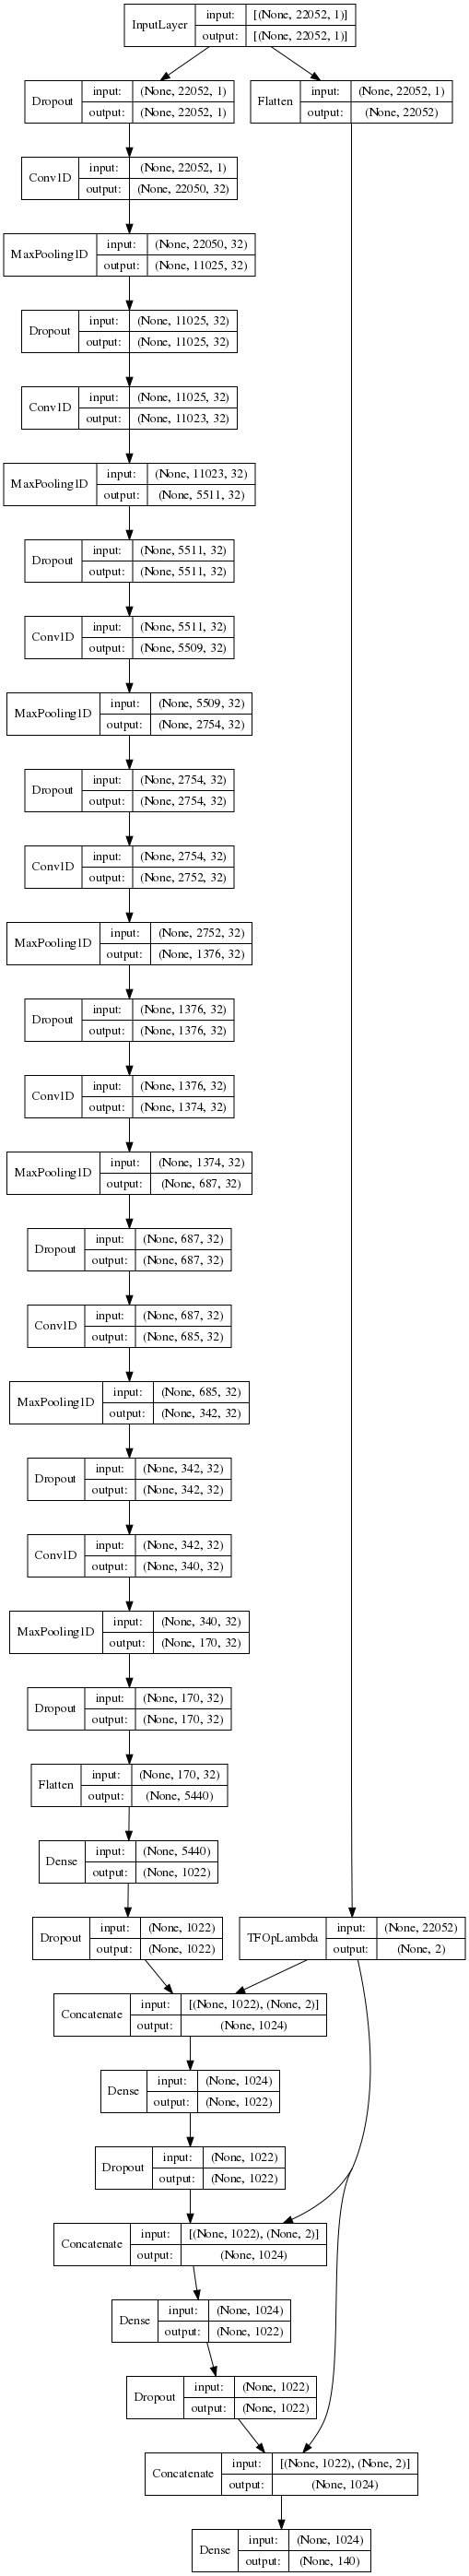

In [21]:
display(plot_model(model, show_layer_names=False, show_shapes=True, dpi=72))

In [22]:
# checkpoint_filepath = './cite_v32/checkpoint{epoch:02d}'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='loss', save_freq=15*100, save_best_only=False, mode='auto')

In [23]:
kf = KFold(n_splits = 8, shuffle = True, random_state=123)
score_list = []
b_size = 128
idx_tr, idx_va = next(kf.split(cite_train_x_raw))

In [24]:
training_generator = MultiomeSequence(cite_train_x_raw_new[idx_tr], cite_train_y_raw[idx_tr], batch_size=b_size)
validation_generator = MultiomeSequence(cite_train_x_raw_new[idx_va], cite_train_y_raw[idx_va], batch_size=b_size)
# retraining_generator = MultiomeSequence(cite_train_x_raw_new, cite_train_y_raw, batch_size=b_size)

In [25]:
epoc=200
# train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epochs, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/200
485/485 [==============================] - 44s 87ms/step - loss: -0.7959
Epoch 2/200
485/485 [==============================] - 42s 87ms/step - loss: -0.8048
Epoch 3/200
485/485 [==============================] - 43s 88ms/step - loss: -0.8420
Epoch 4/200
485/485 [==============================] - 43s 88ms/step - loss: -0.8570
Epoch 5/200
485/485 [==============================] - 45s 92ms/step - loss: -0.8635 - val_loss: -0.8777
Epoch 6/200
485/485 [==============================] - 43s 89ms/step - loss: -0.8679
Epoch 7/200
485/485 [==============================] - 43s 89ms/step - loss: -0.8703
Epoch 8/200
485/485 [==============================] - 44s 90ms/step - loss: -0.8719
Epoch 9/200
485/485 [==============================] - 43s 89ms/step - loss: -0.8730
Epoch 10/200
485/485 [==============================] - 45s 93ms/step - loss: -0.8744 - val_loss: -0.8844
Epoch 11/200
485/485 [==============================] - 43s 88ms/step - loss: -0.8749
Epoch 12/200
485/485 [=

485/485 [==============================] - 41s 84ms/step - loss: -0.8893
Epoch 93/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8892
Epoch 94/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8893
Epoch 95/200
485/485 [==============================] - 43s 88ms/step - loss: -0.8895 - val_loss: -0.8974
Epoch 96/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8893
Epoch 97/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8895
Epoch 98/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8894
Epoch 99/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8896
Epoch 100/200
485/485 [==============================] - 43s 88ms/step - loss: -0.8895 - val_loss: -0.8976
Epoch 101/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8897
Epoch 102/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8896
Epoch 103/200
485/485 [=

485/485 [==============================] - 41s 84ms/step - loss: -0.8917
Epoch 183/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8917
Epoch 184/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8918
Epoch 185/200
485/485 [==============================] - 43s 88ms/step - loss: -0.8919 - val_loss: -0.8986
Epoch 186/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8918
Epoch 187/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8917
Epoch 188/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8917
Epoch 189/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8917
Epoch 190/200
485/485 [==============================] - 43s 88ms/step - loss: -0.8918 - val_loss: -0.8990
Epoch 191/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8918
Epoch 192/200
485/485 [==============================] - 41s 84ms/step - loss: -0.8918
Epoch 193/200
485

In [26]:
model.save("./model/cite_v35")

INFO:tensorflow:Assets written to: ./model/cite_v35/assets


In [27]:
# del model
gc.collect()
K.clear_session()


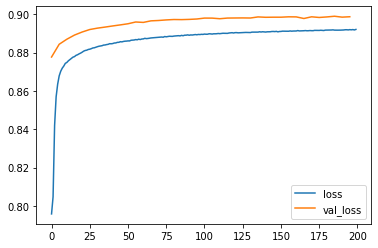

In [32]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [33]:
train_hist.history

{'loss': [-0.7958659529685974,
  -0.8047864437103271,
  -0.842028796672821,
  -0.8569774627685547,
  -0.8635438680648804,
  -0.8678951263427734,
  -0.8702969551086426,
  -0.8719107508659363,
  -0.8730071783065796,
  -0.8744118809700012,
  -0.8748939633369446,
  -0.8757479190826416,
  -0.8764033317565918,
  -0.8770111203193665,
  -0.8776485323905945,
  -0.8779400587081909,
  -0.8785927295684814,
  -0.8789012432098389,
  -0.8793779611587524,
  -0.8797558546066284,
  -0.8802304863929749,
  -0.8807852864265442,
  -0.8811277151107788,
  -0.8812898993492126,
  -0.8816623687744141,
  -0.8818084001541138,
  -0.8820826411247253,
  -0.8824484348297119,
  -0.8825506567955017,
  -0.8828373551368713,
  -0.8831171989440918,
  -0.8833489418029785,
  -0.8835172653198242,
  -0.8836281895637512,
  -0.8839495778083801,
  -0.8840079307556152,
  -0.8842164278030396,
  -0.8843415975570679,
  -0.884685218334198,
  -0.8846365809440613,
  -0.8847440481185913,
  -0.885031521320343,
  -0.8850702047348022,
  -0.8

In [ ]:
cite_train_x_gen = MultiomeSequence_test(cite_train_x_raw, batch_size=4)
train_pred_y = model.predict(cite_train_x_gen)

In [ ]:
train_pred_y.shape

In [ ]:
pd.DataFrame(train_pred_y.reshape(-1)).hist(bins=500)

In [ ]:
pd.DataFrame(cite_train_y_raw.reshape(-1)).hist(bins=500)
plt.xlim(-5,20)

In [ ]:
cite_train_y_raw.shape

In [ ]:
CorrelationLoss_new()(train_pred_y, cite_train_y_raw)

In [ ]:
cite_train_x_raw.shape

In [ ]:
retraining_generator = MultiomeSequence(cite_train_x_raw, cite_train_y_raw, batch_size=b_size)

In [ ]:
%%time
# Cross-validation
# multi_train_x = multi_train_x_raw
# multi_train_y = multi_train_y_raw
gc.collect()
K.clear_session()
model = None
model = my_model_2(cite_train_x_raw.shape[1], cite_train_y_raw.shape[1], 4096, 4, init_dropout=0.2, layer_dropout=0.7, activation='selu')
print(model.summary())
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss = CorrelationLoss_new())

In [37]:
epoc = 6000
train_hist = model.fit(retraining_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/1000
17/17 [==============================] - 15s 819ms/step - loss: -0.7471
Epoch 2/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.8016
Epoch 3/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8018
Epoch 4/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8032
Epoch 5/1000
17/17 [==============================] - 29s 2s/step - loss: -0.8033 - val_loss: -0.8060
Epoch 6/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8028
Epoch 7/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.8023
Epoch 8/1000
17/17 [==============================] - 14s 820ms/step - loss: -0.8036
Epoch 9/1000
17/17 [==============================] - 14s 822ms/step - loss: -0.8035
Epoch 10/1000
17/17 [==============================] - 28s 2s/step - loss: -0.8034 - val_loss: -0.8056
Epoch 11/1000
17/17 [==============================] - 14s 822ms/step - loss: -0.8042
Epoch 12/1000
17/17 [========

17/17 [==============================] - 14s 821ms/step - loss: -0.9003
Epoch 183/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9007
Epoch 184/1000
17/17 [==============================] - 14s 820ms/step - loss: -0.9009
Epoch 185/1000
17/17 [==============================] - 28s 2s/step - loss: -0.9021 - val_loss: -0.9085
Epoch 186/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9016
Epoch 187/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9015
Epoch 188/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9008
Epoch 189/1000
17/17 [==============================] - 14s 819ms/step - loss: -0.9011
Epoch 190/1000
17/17 [==============================] - 28s 2s/step - loss: -0.9020 - val_loss: -0.9091
Epoch 191/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9025
Epoch 192/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9026
Epoch 193/1000
17/17 [==

KeyboardInterrupt: 

In [ ]:
epoc = 1000
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

# Predicting

In [44]:
cite_test_df = pd.read_hdf(FP_CITE_TEST_INPUTS)
cite_test_df = cite_test_df.merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')
cite_test_x = cite_test_df.values
cite_test_x.shape

(48663, 22052)

In [45]:
cite_test_x_gen = MultiomeSequence_test(cite_test_x, batch_size=9)

In [46]:
test_pred = model.predict(cite_test_x_gen)

In [64]:
test_pred=test_pred/2000

In [66]:
test_pred.shape

(48663, 140)

In [48]:
test_pred

array([[-16872.78  , -16529.574 , -14850.824 , ..., -16382.986 ,
         -5617.318 ,  -9523.265 ],
       [-15983.761 , -15896.216 , -14268.212 , ..., -14856.228 ,
         -5932.4873,  -8633.405 ],
       [-13394.605 , -11822.872 , -10215.061 , ..., -12998.426 ,
         12856.708 ,  -5741.645 ],
       ...,
       [-20151.12  , -11562.627 , -14371.454 , ..., -18493.584 ,
        -15040.005 ,  -4159.7075],
       [-18793.92  , -15940.084 , -12431.3   , ..., -17092.123 ,
         24560.777 ,   7430.989 ],
       [-17449.967 , -14142.281 , -10855.673 , ..., -15670.2705,
         31288.357 ,   9102.683 ]], dtype=float32)

In [49]:
gc.collect()

24749

In [69]:
submission_prev = pd.read_csv('submission 804 NN.csv')['target']

In [70]:
submission_prev

0           9.460453e-02
1          -1.623624e-01
2          -4.053319e-01
3          -3.025821e-01
4           1.114355e+00
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float64

In [71]:
test_pred.ravel().shape

(6812820,)

In [72]:
submission_prev.iloc[:len(test_pred.ravel())] = test_pred.ravel()

In [73]:
submission_prev = pd.DataFrame(submission_prev)

In [74]:
submission_prev.index.name="row_id"

In [75]:
submission_prev

,target
row_id,
0,-8.436390e+00
1,-8.264787e+00
2,-7.425412e+00
3,2.052546e+00
4,5.813356e+00
...,...
65744175,9.840503e+09
65744176,0.000000e+00
65744177,0.000000e+00


In [76]:
submission_prev.to_csv("submission.csv")